#### TASK WITH RDD

Just change the `year` value from dropdown and run the code. It will generate all the required data for that year !

In [0]:
dbutils.widgets.dropdown("YEAR", "2021", [str(x) for x in ['2019','2020','2021']])
widget_year_value = dbutils.widgets.get("YEAR")
string_year = widget_year_value

### Problem Number (1)

In [0]:
from itertools import islice
file_path = 'dbfs:/FileStore/tables/clinicaltrial_'+string_year+'.csv'
uploadTrialRDD = sc.textFile(file_path)
clinicaltrialRDD = uploadTrialRDD.mapPartitionsWithIndex(
    lambda idx, it: islice(it, 1, None) if idx == 0 else it 
)
clinicaltrialRDD.take(5)

Out[2]: ['NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||',
 'NCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|',
 'NCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|',
 'NCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|',
 'NCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|']

In [0]:
clinicaltrialRDD.distinct().count()

Out[3]: 387261

### Problem Number (2)

In [0]:
countTypeRDD = clinicaltrialRDD.map(lambda x: x.split('|'))\
                                .map(lambda field: (field[5],1))\
                                .reduceByKey(lambda x, y: x+y)\
                                .sortBy(lambda sort: sort[1], ascending=False)
countTypeRDD.collect()

Out[4]: [('Interventional', 301472),
 ('Observational', 77540),
 ('Observational [Patient Registry]', 8180),
 ('Expanded Access', 69)]

### Problem Number (3)

In [0]:
countConditionRDD = clinicaltrialRDD.map(lambda x: x.split('|'))\
                                    .flatMap(lambda z: z[7].split(','))\
                                    .map(lambda y: (y,1))\
                                    .filter(lambda n: n[0] != '')\
                                    .reduceByKey(lambda x,y: x+y)\
                                    .sortBy(lambda z: z[1], False)
countConditionRDD.take(5)

Out[5]: [('Carcinoma', 13389),
 ('Diabetes Mellitus', 11080),
 ('Neoplasms', 9371),
 ('Breast Neoplasms', 8640),
 ('Syndrome', 8032)]

### Problem Number (4)

In [0]:
clinical_conditionRDD = clinicaltrialRDD.map(lambda x: x.split('|'))\
                                        .flatMap(lambda y: y[7].split(','))\
                                        .map(lambda z: (z,1))\
                                        .filter(lambda n: n[0] != '')
clinical_conditionRDD.take(15)

Out[6]: [('Autistic Disorder', 1),
 ('Autism Spectrum Disorder', 1),
 ('Diabetes Mellitus', 1),
 ('Tuberculosis', 1),
 ('Lung Diseases', 1),
 ('Pulmonary Disease', 1),
 ('Diverticular Diseases', 1),
 ('Diverticulum', 1),
 ('Diverticulosis', 1),
 ('Asthma', 1),
 ('Hypoventilation', 1),
 ('Lymphoma', 1),
 ('Myositis', 1),
 ('Diabetes Mellitus', 1),
 ('Hypertension', 1)]

In [0]:
uploadMeshRDD = sc.textFile('/FileStore/tables/mesh.csv')
meshRDD = uploadMeshRDD.mapPartitionsWithIndex(
    lambda idx, it: islice(it, 1, None) if idx == 0 else it 
)

In [0]:
meshRDD.take(5)

Out[8]: ['Calcimycin,D03.633.100.221.173',
 'A-23187,D03.633.100.221.173',
 'Temefos,D02.705.400.625.800',
 'Temefos,D02.705.539.345.800',
 'Temefos,D02.886.300.692.800']

In [0]:
customMeshRDD = meshRDD.map(lambda x: x.split(','))\
                        .map(lambda y: (y[0],y[1]))
customMeshRDD.take(15)

Out[9]: [('Calcimycin', 'D03.633.100.221.173'),
 ('A-23187', 'D03.633.100.221.173'),
 ('Temefos', 'D02.705.400.625.800'),
 ('Temefos', 'D02.705.539.345.800'),
 ('Temefos', 'D02.886.300.692.800'),
 ('Abate', 'D02.705.400.625.800'),
 ('Abate', 'D02.705.539.345.800'),
 ('Abate', 'D02.886.300.692.800'),
 ('Difos', 'D02.705.400.625.800'),
 ('Difos', 'D02.705.539.345.800'),
 ('Difos', 'D02.886.300.692.800'),
 ('Abattoirs', 'J01.576.423.200.700.100'),
 ('Abattoirs', 'J03.540.020'),
 ('Abbreviations as Topic', 'L01.559.598.400.556.131'),
 ('Acronyms as Topic', 'L01.559.598.400.556.131')]

In [0]:
joinedRDD = clinical_conditionRDD.join(customMeshRDD)
joinedRDD.take(10)

Out[10]: [('Autistic Disorder', (1, 'F03.625.164.113.500')),
 ('Autistic Disorder', (1, 'F03.625.164.113.500')),
 ('Autistic Disorder', (1, 'F03.625.164.113.500')),
 ('Autistic Disorder', (1, 'F03.625.164.113.500')),
 ('Autistic Disorder', (1, 'F03.625.164.113.500')),
 ('Autistic Disorder', (1, 'F03.625.164.113.500')),
 ('Autistic Disorder', (1, 'F03.625.164.113.500')),
 ('Autistic Disorder', (1, 'F03.625.164.113.500')),
 ('Autistic Disorder', (1, 'F03.625.164.113.500')),
 ('Autistic Disorder', (1, 'F03.625.164.113.500'))]

In [0]:
clinicMeshRDD = joinedRDD.map(lambda r: r[1])\
                    .map(lambda z: (z[1].split('.'),z[0]))\
                    .map(lambda w: (w[0][0],w[1]))\
                    .reduceByKey(lambda u,v: u+v)\
                    .sortBy(lambda x: x[1], ascending=False)
clinicMeshRDD.take(10)

Out[11]: [('C04', 143994),
 ('C23', 136079),
 ('C01', 106674),
 ('C14', 94523),
 ('C10', 92310),
 ('C06', 85646),
 ('C08', 70720),
 ('C13', 42599),
 ('C18', 41276),
 ('C12', 40161)]

### Problem Number (5)

In [0]:
uploadedPharmaRDD = sc.textFile('/FileStore/tables/pharma.csv')
pharmaRDD = uploadedPharmaRDD.mapPartitionsWithIndex(
    lambda idx, it: islice(it, 1, None) if idx == 0 else it 
)
pharmaRDD.take(5)

Out[12]: ['"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the company\'s carotid, biliary and peripheral vascular products.","federal","agency action","Justice Department Civil Division","civil","","","","","","","","","","","","USA","Illinois","publicly traded","ABT","pharmaceuticals","pharmaceuticals","https://www.justice.gov/opa/pr/abbott-laboratories-pays-us-5475-million-settle-claims-company-paid-kickbacks-physicians",""',
 '"Abbott Laboratories Inc.","AbbVie","$1,500,000,000","$0","$1,500,000,000","2012","20120507","healthcare-related offenses","off-label or unapproved promotion of medical products","","Global Health Care Company Abbott Laboratories Inc. has pleaded guilty and agreed to

In [0]:
parent_companyRDD = pharmaRDD.map(lambda x: x.split(','))\
                            .map(lambda z: z[1].replace('"',''))\
                            .map(lambda row: (row, (row,0)))
parent_companyRDD.take(10)

Out[13]: [('Abbott Laboratories', ('Abbott Laboratories', 0)),
 ('AbbVie', ('AbbVie', 0)),
 ('AbbVie', ('AbbVie', 0)),
 (' Inc.', (' Inc.', 0)),
 ('Johnson & Johnson', ('Johnson & Johnson', 0)),
 ('Abbott Laboratories', ('Abbott Laboratories', 0)),
 (' Inc.', (' Inc.', 0)),
 ('Johnson & Johnson', ('Johnson & Johnson', 0)),
 (' a division of Ethicon Inc.', (' a division of Ethicon Inc.', 0)),
 ('Abbott Laboratories', ('Abbott Laboratories', 0))]

In [0]:
sponsorRDD = clinicaltrialRDD.map(lambda x: x.split('|'))\
                             .map(lambda y: (y[1], (y[1],1)))
sponsorRDD.take(10)

Out[14]: [('The University of Hong Kong', ('The University of Hong Kong', 1)),
 ('Duke University', ('Duke University', 1)),
 ('Universidade Federal do Rio de Janeiro',
  ('Universidade Federal do Rio de Janeiro', 1)),
 ('Istanbul Medeniyet University', ('Istanbul Medeniyet University', 1)),
 ('University of Roma La Sapienza', ('University of Roma La Sapienza', 1)),
 ('Consorzio Futuro in Ricerca', ('Consorzio Futuro in Ricerca', 1)),
 ('Ankara University', ('Ankara University', 1)),
 ('Ruijin Hospital', ('Ruijin Hospital', 1)),
 ('Washington University School of Medicine',
  ('Washington University School of Medicine', 1)),
 ('Orphazyme', ('Orphazyme', 1))]

In [0]:
leftJoinedRDD = sponsorRDD.leftOuterJoin(parent_companyRDD)
leftJoinedRDD.take(10)

Out[15]: [('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None)),
 ('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None)),
 ('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None)),
 ('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None)),
 ('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None)),
 ('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None)),
 ('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None)),
 ('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None)),
 ('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None)),
 ('University of Roma La Sapienza',
  (('University of Roma La Sapienza', 1), None))]

In [0]:
clinicPharmaRDD = leftJoinedRDD.filter(lambda x: x[1][1] is None)\
                        .map(lambda y: y[1][0])\
                        .reduceByKey(lambda w,v: w+v)\
                        .sortBy(lambda x: x[1], ascending=False)
clinicPharmaRDD.take(10)

Out[16]: [('National Cancer Institute (NCI)', 3218),
 ('M.D. Anderson Cancer Center', 2414),
 ('Assistance Publique - Hôpitaux de Paris', 2369),
 ('Mayo Clinic', 2300),
 ('Merck Sharp & Dohme Corp.', 2243),
 ('Assiut University', 2154),
 ('Novartis Pharmaceuticals', 2088),
 ('Massachusetts General Hospital', 1971),
 ('Cairo University', 1928),
 ('Hoffmann-La Roche', 1828)]

### Problem Number (6)

In [0]:
completed_studiesRDD = clinicaltrialRDD.map(lambda x: x.split('|'))\
                                        .filter(lambda p: p[2] == 'Completed')\
                                        .map(lambda y: y[4])\
                                        .filter(lambda z: z != '' and z != 'Completion')\
                                        .map(lambda c: c.split())\
                                        .filter(lambda p: p[1] == string_year)\
                                        .map(lambda q: (q[0],1))\
                                        .reduceByKey(lambda u,v: u+v)
completed_studiesRDD.collect()

Out[17]: [('May', 984),
 ('Jan', 1131),
 ('Jun', 1094),
 ('Mar', 1227),
 ('Feb', 934),
 ('Aug', 700),
 ('Apr', 967),
 ('Jul', 819),
 ('Oct', 187),
 ('Sep', 528)]

In [0]:
import calendar
d = {i:e for e,i in enumerate(calendar.month_abbr[1:],1)}
resultRDD = completed_studiesRDD.sortBy(keyfunc=lambda x: d.get(x[0]))

In [0]:
resultRDD.collect()

Out[19]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

### Visualization

In [0]:
month_list = resultRDD.map(lambda x: x[0]).collect()
counter_list = resultRDD.map(lambda y: y[1]).collect()

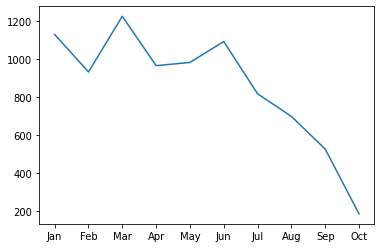

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(month_list, counter_list);

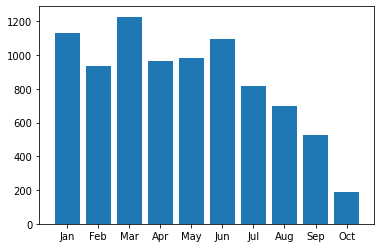

In [0]:
plt.bar(month_list, counter_list)
plt.show()